<a id="title_ID"></a>
# Plotting a Catalog over a Kepler Full Frame Image File
<br> This tutorial demonstrates how to access the WCS (World Coordinate System) from a full frame image file and use this data to plot a catalog of objects over the FFI. 
<br>
<img style="float: right;" src="ffi_tic_plot.png" alt="ffi_tic_plot" width="500"/>
### Table of Contents
<div style="text-align: left"> <br> [Introduction](#intro_ID) <br> [Imports](#imports_ID) <br> [Getting the Data](#data_ID) <br> [File Information](#fileinfo_ID) <br> [Displaying Image Data](#image_ID) <br> [Overplotting Objects](#overplot_ID) <br> [Additional Resources](#resources_ID) <br> [About this Notebook](#about_ID) </div>

***

<a id="intro_ID"></a>
## Introduction
**Full Frame Image file background:** A Full Frame Image (FFI) contains values for every pixel in each of the 84 channels. Standard calibrations, such as flat fields, blacks, and smears have been applied to the calibrated FFIs. These files also contain a World Coordinate System (WCS) that attaches RA and Dec coordinates to pixel x and y values.

**Some notes about the file:** kplr2009170043915_ffi-cal.fits
<br>The filename contains phrases for identification, where
- kplr = Kepler 
- 2009170043915 = year 2009, day 170, time 04:39:15
- ffi-cal = calibrated FFI image

**Defining some terms:**
 - **HDU:** Header Data Unit; a FITS file is made up of Header or Data units that contain information, data, and metadata relating to the file. The first HDU is called the primary, and anything that follows is considered an extension. 
 - **TIC:** TESS Input Catalog; a catalog of luminous sources on the sky to be used by the TESS mission. We will use the TIC in this notebook to query a catalog of objects that we will then plot over an image from Kepler.
 - **WCS:** World Coordinate System; coordinates attached to each pixel of an N-dimensional image of a FITS file. For example, a specified celestial RA and Dec associated with pixel location in the image. 
 
For more information about the Kepler mission and collected data, visit the [Kepler archive page](https://archive.stsci.edu/kepler/). To read more details about light curves and important data terms, look in the [Kepler archive manual](https://archive.stsci.edu/kepler/manuals/archive_manual.pdf#page=25).

[Top of Page](#title_ID)

***

<a id="imports_ID"></a>
## Imports
Let's start by importing some libraries to the environment: 
- *numpy* to handle array functions
- *astropy.io fits* for accessing fits files
- *astropy.wcs WCS* to project the World Coordinate System on the plot
- *astropy.table Table* for creating tidy tables of the data
- *matplotlib.pyplot* for plotting data

In [2]:
%matplotlib inline
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
import matplotlib.pyplot as plt

[Top of Page](#title_ID)

***

<a id="data_ID"></a>
## Getting the Data
Start by importing libraries from Astroquery. For a longer, more detailed description using of Astroquery, please visit this [tutorial](https://github.com/spacetelescope/MAST-API-Notebooks/blob/master/MUG2018_APITutorial_Astroquery.ipynb) or read the Astroquery [documentation](https://astroquery.readthedocs.io/en/latest/#).

In [5]:
from astroquery.mast import Mast
from astroquery.mast import Observations

<br>Next, we need to find the data file. This is similar to searching for the data using the [MAST Portal](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) in that we will be using certain keywords to find the file. The object we are looking for is kplr2009170043915, collected by the Kepler spacecraft. We are searching for an FFI file of this object:

In [6]:
kplrObs = Observations.query_criteria(obs_id="kplr2009170043915_84", obs_collection="KeplerFFI")
kplrProds = Observations.get_product_list(kplrObs[0])
yourProd = Observations.filter_products(kplrProds, extension='kplr2009170043915_ffi-cal.fits', 
                                        mrp_only=False)
yourProd

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid
str10,str9,str5,str20,str22,str1,str106,str9,str28,str1,str1,str6,str1,str1,str37,int64,str10
4000002693,KeplerFFI,image,kplr2009170043915_84,Full Frame Image (FFI),C,mast:KeplerFFI/url/missions/kepler/ffi/kplr2009170043915_ffi-cal.fits,SCIENCE,Minimum Recommended Products,--,--,Kepler,--,--,kplr2009170043915_ffi-cal.fits,407882880,4000002693


<br>Now that we've found the data file, we can download it using the reults shown in the table above:

In [7]:
Observations.download_products(yourProd, mrp_only=False, cache=False)

Local Path,Status,Message,URL
str76,str8,object,object
./mastDownload/KeplerFFI/kplr2009170043915_84/kplr2009170043915_ffi-cal.fits,COMPLETE,None,None


[Top of Page](#title_ID)

***

 <a id="extension_ID"></a>
## Reading FITS Extensions
<br>Now that we have the file, we can start working with the data. We will begin by assigning a shorter name to the file to make it easier to use. Then, using the info function from astropy.io.fits, we can see some information about the FITS Header Data Units:

In [8]:
filename = "./mastDownload/KeplerFFI/kplr2009170043915_84/kplr2009170043915_ffi-cal.fits"
fits.info(filename)

Filename: ./mastDownload/KeplerFFI/kplr2009170043915_84/kplr2009170043915_ffi-cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      57   ()      
  1  MOD.OUT 2.1    1 ImageHDU       100   (1132, 1070)   float32   
  2  MOD.OUT 2.2    1 ImageHDU       100   (1132, 1070)   float32   
  3  MOD.OUT 2.3    1 ImageHDU       100   (1132, 1070)   float32   
  4  MOD.OUT 2.4    1 ImageHDU       100   (1132, 1070)   float32   
  5  MOD.OUT 3.1    1 ImageHDU       100   (1132, 1070)   float32   
  6  MOD.OUT 3.2    1 ImageHDU       100   (1132, 1070)   float32   
  7  MOD.OUT 3.3    1 ImageHDU       100   (1132, 1070)   float32   
  8  MOD.OUT 3.4    1 ImageHDU       100   (1132, 1070)   float32   
  9  MOD.OUT 4.1    1 ImageHDU       100   (1132, 1070)   float32   
 10  MOD.OUT 4.2    1 ImageHDU       100   (1132, 1070)   float32   
 11  MOD.OUT 4.3    1 ImageHDU       100   (1132, 1070)   float32   
 12  MOD.OUT 4.4    1 ImageHDU       100 

- **No. 0 (Primary): **
<br>This HDU contains meta-data related to the entire file.
- **No. 1-84 (Image): **
 <br>Each of the 84 image extensions contains an array that can be plotted as an image. We will plot one in this tutorial along with catalog data. 

<br>Let's say we wanted to see more information about the header and extensions than what the fits.info command gave us. For example, we can access information stored in the header of any of the Image extensions (No.1 - 84, MOD.OUT). The following line opens the FITS file, writes the first HDU extension into header1, and then closes the file. Only 24 rows of data are displayed here but you can view them all by adjusting the range: 

In [29]:
with fits.open(filename) as hdulist: 
    header1 = hdulist[1].header
  
print(repr(header1[1:25]))

BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / NAXIS                                          
NAXIS1  =                 1132 / length of first array dimension                
NAXIS2  =                 1070 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
INHERIT =                    T / inherit the primary header                     
EXTNAME = 'MOD.OUT 2.1'        / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
TELESCOP= 'Kepler  '           / telescope                                      
INSTRUME= 'Kepler Photometer'  / detector type                                  
CHANNEL =                    1 / CCD channel                                    
SKYGROUP=                   

[Top of Page](#title_ID)

***

<a id="image_ID"></a>
## Displaying Image Data
<br>First, let's find the WCS information associated with the FITS file we are using. One way to do this is to access the header and print the rows containing the relevant data (54 - 65). This gives us the reference coordinates (CRVAL1, CRVAL2) that correspond to the reference pixels:

In [45]:
with fits.open(filename) as hdulist: 
    header1 = hdulist[1].header
  
print(repr(header1[54:61]))

WCSAXES =                    2 / number of WCS axes                             
CTYPE1  = 'RA---TAN-SIP'       / Gnomonic projection + SIP distortions          
CTYPE2  = 'DEC--TAN-SIP'       / Gnomonic projection + SIP distortions          
CRVAL1  =    290.4620065226813 / RA at CRPIX1, CRPIX2                           
CRVAL2  =    38.32946356799192 / DEC at CRPIX1, CRPIX2                          
CRPIX1  =                533.0 / X reference pixel                              
CRPIX2  =                521.0 / Y reference pixel                              


<br>Let's pick an image HDU and display its array. We can also choose to print the length of the array to get an idea of the dimensions of the image:

In [10]:
with fits.open(filename) as hdulist:
    imgdata = hdulist[1].data
    
print(len(imgdata))
print(imgdata)

1070
[[ 2.8926212e+01  5.7084761e+00  2.8518679e+00 ...  2.3335369e-02
   3.8872162e-01  2.4866710e+00]
 [ 2.5392172e+01  4.9826989e+00  2.3192320e+00 ... -3.5835370e-01
   9.4126135e-01  1.4343496e-01]
 [ 2.7359493e+01  5.5186005e+00  1.1480473e+00 ...  5.8914202e-01
  -2.0753877e+00  2.3046710e-01]
 ...
 [-3.8266034e+02 -9.6860485e+00  1.7396482e+01 ...  1.3947951e+00
  -8.3887035e-01  9.5944041e-01]
 [-3.8286859e+02 -5.6933088e+00  2.0129442e+01 ... -7.7534288e-01
   1.5140564e+00  1.3752979e+00]
 [-3.8489960e+02 -3.4747849e+00  1.5189555e+00 ...  1.0207459e+00
   6.7454106e-01 -2.0665376e-02]]


We can now plot this array as an image:

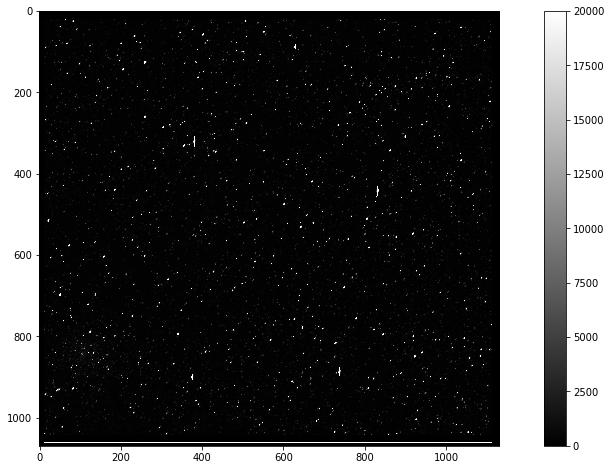

In [59]:
fig = plt.figure(figsize=(16,8))
plt.imshow(imgdata, cmap=plt.cm.gray)
plt.colorbar()
plt.clim(0,20000)

Now that we've seen the image and the WCS information, we can plot FFI with a WCS projection. To do this, first we will access the file header and assign a WCS object. Then we will plot the image with the projection, and add labels and a grid for usability:

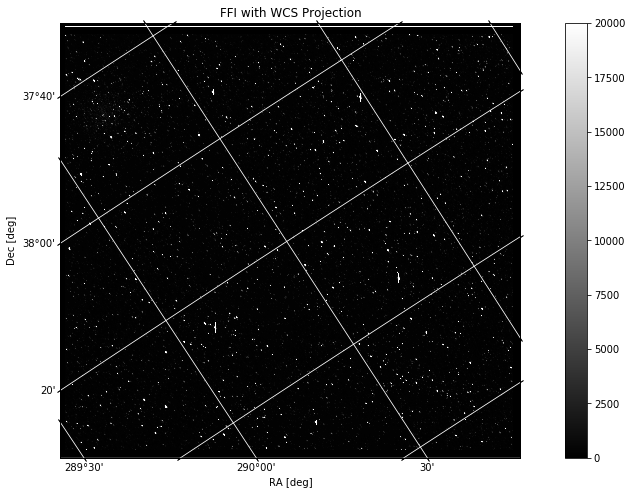

In [53]:
hdu = fits.open(filename)[1]
wcs = WCS(hdu.header)

fig = plt.figure(figsize=(16,8))
ax = plt.subplot(projection=wcs) 
im = ax.imshow(hdu.data, cmap=plt.cm.gray, origin='lower', clim=(0,20000))
fig.colorbar(im)

plt.title('FFI with WCS Projection')
ax.set_xlabel('RA [deg]')
ax.set_ylabel('Dec [deg]')
ax.grid(color='white', ls='solid')

[Top of Page](#title_ID)

***

<a id="catalog_ID"></a>
## Getting the Catalog Data

Now that we have an image, we can use astroquery to retrieve a catalog of objects and overlay it onto the image. First, we will start with importing catalog data from astroquery:

In [12]:
from astroquery.mast import Catalogs

We will query a catalog of objects from TIC (TESS Input Catalog). For more information about TIC, follow this [link](https://archive.stsci.edu/missions/tess/doc/tic_v5_drn.pdf). Our search will be centered on the same RA and Declination listed in the header of the FFI image and will list objects within a 1 degree radius of that location. It might take a couple seconds longer than usual for this cell to run:

**why tic??? explain...**

In [13]:
catalogData = Catalogs.query_region("290.4620065226813  38.32946356799192", radius="0.7 deg", catalog="TIC")
dattab = Table(catalogData)
dattab

ID,ra,dec,pmRA,pmDEC,Tmag,objType,typeSrc,version,HIP,TYC,UCAC,TWOMASS,SDSS,ALLWISE,GAIA,APASS,KIC,POSflag,e_pmRA,e_pmDEC,PMflag,plx,e_plx,PARflag,gallong,gallat,eclong,eclat,Bmag,e_Bmag,Vmag,e_Vmag,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,TWOMflag,prox,w1mag,e_w1mag,w2mag,e_w2mag,w3mag,e_w3mag,w4mag,e_w4mag,GAIAmag,e_GAIAmag,e_Tmag,TESSflag,SPFlag,Teff,e_Teff,logg,e_logg,MH,e_MH,rad,e_rad,mass,e_mass,rho,e_rho,lumclass,lum,e_lum,d,e_d,ebv,e_ebv,numcont,contratio,disposition,duplicate_id,priority,dstArcSec
str11,float64,float64,float64,float64,float64,str8,str5,str8,str5,str12,str10,str17,str19,str19,str19,str8,str7,str8,float64,float64,str6,float64,float64,str4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64,float64,float64,int64,float64,str1,str1,float64,float64
122451116,290.458572,38.330704,8.65012,-24.0384,17.834,STAR,2mass,20180610,--,--,--,19215005+3819505,1237668681001865024,J192150.05+381950.1,2052812123437282560,--,3231494,tmgaia,3.03321,3.033,hsoy,--,--,--,70.553838,10.980659,302.66791,59.47125,--,--,--,--,30.0,50.0,21.1759,0.0407339,19.501,0.0154282,18.3125,0.0104299,17.5937,0.0168285,16.24,0.101,15.502,0.124,15.5,0.211,ABC-222-111-000-0-0,17.8,15.309,0.034,15.826,0.108,12.987,--,9.346,--,18.9431,0.0277311,0.05,gaiaj,--,--,--,--,--,--,--,--,--,--,--,--,--,DWARF,--,--,--,--,--,--,--,--,--,--,--,10.677775645399649
122451103,290.460189,38.335473,-6.45462,-16.629,17.693,STAR,2mass,20180610,--,--,--,19215044+3820077,1237668681001862726,--,2052812123437286656,--,3231500,tmgaia,3.0447,3.04422,hsoy,--,--,--,70.55877,10.981611,302.672881,59.475489,--,--,--,--,22.7966,0.344667,20.1662,0.0197298,18.7987,0.010067,18.2431,0.00995303,17.8603,0.0197373,16.559,0.125,15.631,--,15.55,--,BUU-200-100-c00-0-0,17.8,--,--,--,--,--,--,--,--,18.516,0.0191208,0.056,gaiaj,--,--,--,--,--,--,--,--,--,--,--,--,--,DWARF,--,--,--,--,--,--,--,--,--,--,--,22.234450067225183
122451132,290.454391,38.323635,-5.55404,-0.934956,16.828,STAR,2mass,20180610,--,--,--,19214905+3819250,1237668681001862417,--,2052811745480155520,--,3231481,tmgaia,2.35572,2.35563,hsoy,--,--,--,70.545901,10.980504,302.657892,59.465347,18.719,0.107,17.912,0.08,20.3251,0.0500266,18.2839,0.00673506,17.5159,0.00542664,17.2232,0.00597096,17.0663,0.0117692,15.993,0.085,15.766,0.147,15.26,0.177,ABC-222-111-000-0-0,7.2,--,--,--,--,--,--,--,--,17.4452,0.00787192,0.039,gaiaj,--,4531.0,175.0,--,--,--,--,--,--,--,--,--,--,DWARF,--,--,--,--,--,--,--,--,--,--,--,30.047472403696602
122451135,290.455889,38.322012,-1.6626,-13.8329,15.781,STAR,2mass,20180610,--,--,642-067566,19214941+3819192,1237668681001862412,--,2052811539321725184,--,3231488,tmgaia,2.2322,2.2322,hsoy,--,--,--,70.544941,10.978736,302.659243,59.463465,17.31,0.079,16.287,1.133,18.0015,0.0126605,16.718,0.00392093,16.2587,0.00383439,16.0848,0.00424111,16.0154,0.00692933,15.22,0.047,14.801,0.065,14.706,0.099,AAA-222-111-000-0-0,7.2,--,--,--,--,--,--,--,--,16.1955,0.00316725,0.025,gaiaj,--,5632.0,188.0,--,--,--,--,--,--,--,--,--,--,DWARF,--,--,--,--,--,--,--,--,--,--,--,31.90787011406792
122451138,290.459003,38.320724,--,--,14.832,STAR,2mass,20180610,--,--,642-067569,19215016+3819146,1237668681001862408,--,2052811539321722752,--,3231495,tmgaia,--,--,--,--,--,--,70.544853,10.975976,302.663174,59.461558,14.795,0.063,15.736,0.103,18.2341,0.0142619,16.2582,0.00358351,15.488,0.00343875,15.2159,0.00375007,15.0562,0.00499314,14.019,0.027,13.636,0.033,13.524,0.042,AAA-222-121-ccc-0-0,5.9,--,--,--,--,--,--,--,--,15.433,0.00196551,0.019,gaiaj,splin,6010.0,179.0,4.30283,--,--,--,1.23178,1.23178,1.11037171,0.1

<br>Let's isolate the RA and Dec columns into a separate table for creating a plot. We will can also filter our results to include only sources brigther than 15 magnitudes in B, which will give us a more managable amount of sources for plotting:

In [14]:
radec = (catalogData['ra','dec','Bmag'])
mask = radec['Bmag'] < 15.0
mag_radec = radec[mask]
print(mag_radec)

    ra        dec     Bmag 
---------- --------- ------
290.459003 38.320724 14.795
290.460477 38.341217  12.29
290.461509 38.341972 12.282
290.432236 38.314801 10.681
 290.49429 38.292011 13.699
290.496087 38.291912 14.087
290.443165 38.282249 14.969
290.521279 38.349394 14.955
290.504496 38.285879 14.606
290.532654 38.335509 14.949
       ...       ...    ...
290.236034 39.005238 14.416
289.590919 38.188117 11.335
290.306598 39.017394  13.86
290.184655 37.665941 13.844
289.936385 37.766642 11.746
291.204884 37.946256 14.959
289.649756  38.61948 14.181
290.971813   38.9041 11.895
290.715839  39.00013  14.99
291.335913 38.471752 13.556
290.294512 39.017124 13.295
Length = 1329 rows


/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


<br>We can plot this table to get an idea of what the catalog looks like visually:

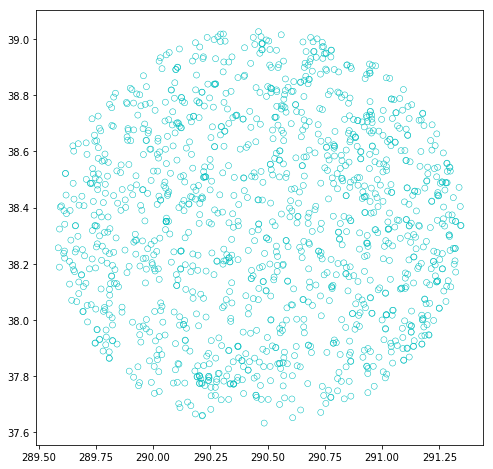

In [15]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.scatter(mag_radec['ra'], mag_radec['dec'], facecolors='none', edgecolors='c', linewidths=0.5)

[Top of Page](#title_ID)

***

<a id="overplot_ID"></a>
## Overplotting Objects

Now that we have a way to display an FFI file and a catalog of objects, we can put the two pieces of data on the same plot. To do this, we will project the World Coordinate System (WCS) as a grid in units of degrees, minutes, and seconds onto the image. Then, we will create a scatter plot of the catalog, similar to the one above, although here we will transform its coordinate values into ICRS (International Celestial Reference System) to be compatible with the WCS projection:

These transformations map the pixel locations in an image to their real-world units, such as their position on the sky sphere. 

**explain the connection between WCS and the FFI images**

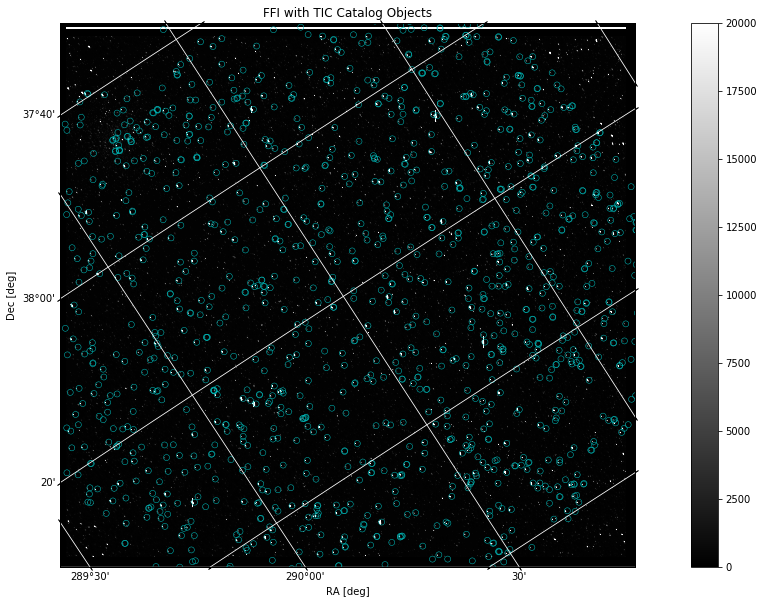

In [54]:
hdu = fits.open(filename)[1]
wcs = WCS(hdu.header)

fig = plt.figure(figsize=(20,10))
ax = plt.subplot(projection=wcs) 
im = ax.imshow(hdu.data, cmap=plt.cm.gray, origin='lower', clim=(0,20000))
fig.colorbar(im)

plt.title('FFI with TIC Catalog Objects')
ax.set_xlabel('RA [deg]')
ax.set_ylabel('Dec [deg]')
ax.grid(color='white', ls='solid')
ax.autoscale(False)

ax.scatter(mag_radec['ra'], mag_radec['dec'],
           facecolors='none', edgecolors='c', linewidths=0.5,
           transform=ax.get_transform('icrs')) # This is needed when projecting onto axes with WCS info

The catalog is displayed here as blue circles that highlight certain objects common in both the Kepler FFI and the TIC search. The image remains in x, y pixel values while the grid is projected in degrees based on the WCS. The projection works off of WCS data in the FFI header to create an accurate grid displaying RA and Dec coordinates that correspond to the original pixel values. **The catalog data is ?????**

[Top of Page](#title_ID)

***

<a id="resources_ID"></a>
## Aditional Resources
For more information about the MAST archive and details about mission data:
<br>
<br>[MAST API](https://mast.stsci.edu/api/v0/index.html)
<br>[Kepler Archive Page (MAST)](https://archive.stsci.edu/kepler/)
<br>[Kepler Archive Manual](https://archive.stsci.edu/kepler/manuals/archive_manual.pdf)
<br>[Exo.MAST website](https://exo.mast.stsci.edu/exo/ExoMast/html/exomast.html)
<br>[TESS Archive Page (MAST)](https://archive.stsci.edu/tess/)

***

<a id="about_ID"></a>
## About this Notebook
**Author:** Josie Bunnell, STScI SASP Intern
<br>**Updated On:** 08/13/2018

***

[Top of Page](#title_ID)
<img style="float: right;" src="stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 